# Lab4.5 Emotional classification with Llama3

Copyright: Vrije Universiteit Amsterdam, Faculty of Humanities, CLTL

Through this notebook, you will annotate a text with Llama version 3, a Generative Large Language Model model released by [Meta](https://llama.meta.com/llama3/). 

You will read a conversation and send the utterances to the Llama server to annotate each using instructions, soca-lled prompting. For running a server locally see the notebook **how-to-install-llama-server.ipynb* from the start of the course. Note that the server needs to run in another terminally in parallel to this notebook. In case you cannot run the server, use the credentials for the CLTL server.

The code for the annotator is given in **llama_annotator.py**. It is an OpenAI client that sends a prompt request to a llama server server for a response.

### Installation of an OpenAI client

To run the annotator, you first need to install the OpenAI client using the following command line. If you ran the code for Llama Chat client you already did this.

In [9]:
#! pip install openai

Once succesfully installed, you can comment out the previous cell and you do not need to do this again when running this notebook. The OpenAI module is now installed on your machine and can be imported. The import will be done by the **llama_annotator.py** script, which we will load next.

## Creating the Llama chatbot

In [1]:
from llama_annotator import LlamaAnnotator

If there are no error messages, we can create a chatbot instance of a LlamaAnnotator as defined in **llama_annotator.py**. We define **annotator** as an instance of a LLamaCAnnotator, where we can specify three additional parameters: the *url* of the server (either local or online), the labels that we want to use for the annoation and optionally examples of the input and output.

In [2]:
### Labels to try
sentiment_labels = ["positive", "negative", "neutral"]
ekman_labels = ["anger", "disgust", "fear", "joy", "sadness", "surprise", "neutral"]
examples = [{"Input": "I love dogs", "Output": "joy"}, {"Input": "I hate cats", "Output": "disgust"}]

annotator = LlamaAnnotator(url="http://localhost:9001/v1", labels=ekman_labels, examples=examples)

My instructions are: [{'role': 'system', 'content': 'You are an intelligent assistant.'}, {'role': 'system', 'content': 'You will receive utterances from a conversation as Input in JSON format.'}, {'role': 'system', 'content': "You need to decide whether one of the following labels apply:['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral']"}, {'role': 'system', 'content': 'Output the most appropriate label in JSON format.'}, {'role': 'system', 'content': 'Do not output anything else.'}, {'role': 'system', 'content': 'Here are a few examples:'}, {'role': 'user', 'content': 'I love dogs'}, {'role': 'system', 'content': 'joy'}, {'role': 'user', 'content': 'I hate cats'}, {'role': 'system', 'content': 'disgust'}]


We are now going to read the conversation that we had before with Llama with our annotations and send these to the server again to annotate.

In [3]:
import pandas as pd

annotation_file = "/Users/piek/Desktop/t-MA-HLT-introduction-2024/ma-hlt-labs-class/lab0.llama/other/all_annotations.json"

df = pd.read_json(annotation_file)
df.head()

,utterance,speaker,turn_id,Gold,Annotator,Votes,Annotators
0,No my name is Coins.,Coins,4,neutral,Yuleum,"[neutral, neutral]","[Yuleum, Lara]"
1,No I am not interested in Coins at all. My par...,Coins,6,anger,Yuleum,"[anger, anger]","[Yuleum, Lara]"
2,"They laugh at it a lot, which makes me annoyed...",Coins,8,anger,Yuleum,"[anger, sadness]","[Yuleum, Lara]"
3,Wow thanks. But my parents have passed away so...,Coins,10,sadness,Yuleum,"[sadness, surprise]","[Yuleum, Lara]"
4,I'm not sure yet. Can you give me some recomme...,Coins,12,neutral,Yuleum,"[neutral, neutral]","[Yuleum, Lara]"


From the Pandas dataframe, we can select the "utterance" column as the list of utterances and give this to the ```anotate``` funciton that is defined for our LlamaAnotator. We store the output in the annotations list.

In [5]:
utterances = df["utterance"]
annotations = annotator.annotate(utterances[:60])
print(annotations[:10])

Processed 10 turns out of 60
Processed 20 turns out of 60
Processed 30 turns out of 60
Processed 40 turns out of 60
Processed 50 turns out of 60
Processed 60 turns out of 60
[{'Input': 'No my name is Coins.', 'Output': 'neutral'}, {'Input': 'No I am not interested in Coins at all. My parents just named it after a pile of coins they saw on their table the day I was born. What a bad name! I hate my name.', 'Output': 'sadness'}, {'Input': 'They laugh at it a lot, which makes me annoyed. I am even thinking about changing my name because I am so stressed!', 'Output': 'anger'}, {'Input': 'Wow thanks. But my parents have passed away some time ago so their opinion does not matter to me anymore. I just want to get a nice name! A normal name.', 'Output': 'anger'}, {'Input': "I'm not sure yet. Can you give me some recommendations?", 'Output': '{\n"anger": 0.8,\n"neutral": 0.2\n}'}, {'Input': 'I want an easy name that a lot of people from different background pronounces the name. ', 'Output': 'neu

We can add the predictions from Llama to the dataframe but Llama does not always precisely follow the instructions e.g. "Output: Output:neutral". We therefore need to clean and filter the output. Specifically, we check if any of the Ekman labels is a substring of the Llama output and then take that value. If none of these is matched, we set the value to None.

In [6]:
test_labels = df['Gold'][:60]

predictions = []
for anno in annotations:
    if 'Output' in anno:
        prediction = anno['Output']
    else:
        prediction = "None"
    llama_label = "None"
    for label in test_labels:
        if label in prediction:
            llama_label = label
    predictions.append(llama_label)
print(predictions)

['neutral', 'sadness', 'anger', 'anger', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'fear', 'anger', 'sadness', 'fear', 'fear', 'surprise', 'fear', 'sadness', 'sadness', 'anger', 'neutral', 'anger', 'anger', 'neutral', 'anger', 'neutral', 'joy', 'joy', 'neutral', 'neutral', 'None', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'anger', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'sadness', 'None', 'neutral', 'neutral', 'neutral', 'None']


Note that Llama may not follow the instructions correctly despite the instructions. It may ignore the JSON format, make up new labels or do other "creative" things being triggered by the input text. Always check the output carefully. If Llama does not generate the right output, we can consider this as an error. In this case, it generates "Output:sadness" as a label in one case.

In [7]:
### We pair the test_labels and the predictions
for pair in zip(test_labels,predictions):
    print(pair)

labels = list(test_labels)+list(predictions)
label_set = sorted(set(labels))
print(label_set)

('neutral', 'neutral')
('anger', 'sadness')
('anger', 'anger')
('sadness', 'anger')
('neutral', 'neutral')
('neutral', 'neutral')
('joy', 'neutral')
('neutral', 'neutral')
('neutral', 'neutral')
('neutral', 'neutral')
('sadness', 'fear')
('anger', 'anger')
('sadness', 'sadness')
('sadness', 'fear')
('fear', 'fear')
('joy', 'surprise')
('neutral', 'fear')
('anger', 'sadness')
('sadness', 'sadness')
('anger', 'anger')
('joy', 'neutral')
('anger', 'anger')
('sadness', 'anger')
('disgust', 'neutral')
('sadness', 'anger')
('neutral', 'neutral')
('joy', 'joy')
('neutral', 'joy')
('joy', 'neutral')
('neutral', 'neutral')
('neutral', 'None')
('neutral', 'neutral')
('neutral', 'neutral')
('sadness', 'neutral')
('joy', 'neutral')
('anger', 'neutral')
('neutral', 'neutral')
('fear', 'anger')
('anger', 'neutral')
('neutral', 'neutral')
('neutral', 'neutral')
('neutral', 'neutral')
('disgust', 'neutral')
('neutral', 'neutral')
('disgust', 'neutral')
('joy', 'neutral')
('joy', 'neutral')
('anger', '

In [8]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

report = classification_report(test_labels,predictions ,digits = 7, target_names=label_set)
print('Llama Ekman ----------------------------------------------------------------')

print(report)

Llama Ekman ----------------------------------------------------------------
              precision    recall  f1-score   support

        None  0.0000000 0.0000000 0.0000000         0
       anger  0.5000000 0.3636364 0.4210526        11
     disgust  0.0000000 0.0000000 0.0000000         3
        fear  0.2500000 0.3333333 0.2857143         3
         joy  0.5000000 0.1111111 0.1818182         9
     neutral  0.5135135 0.8260870 0.6333333        23
     sadness  0.6000000 0.3000000 0.4000000        10
    surprise  0.0000000 0.0000000 0.0000000         1

    accuracy                      0.4666667        60
   macro avg  0.2954392 0.2417710 0.2402398        60
weighted avg  0.4760135 0.4666667 0.4281959        60



/Users/piek/Desktop/t-MA-HLT-introduction-2024/ma-hlt-labs-class/venv2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/piek/Desktop/t-MA-HLT-introduction-2024/ma-hlt-labs-class/venv2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/piek/Desktop/t-MA-HLT-introduction-2024/ma-hlt-labs-class/venv2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `z

We can see that the results are not very good, which we could have guessed from the paired list of values: "joy" is never assigned and "sadness" is assigned when it should not. Think about how to improve the prompt to make it better. 

Confusion matrix SVM
[[ 0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  5  2  0]
 [ 0  0  0  0  0  3  0  0]
 [ 0  1  0  1  0  1  0  0]
 [ 0  0  0  0  1  7  0  1]
 [ 2  0  0  1  1 19  0  0]
 [ 0  3  0  2  0  2  3  0]
 [ 1  0  0  0  0  0  0  0]]


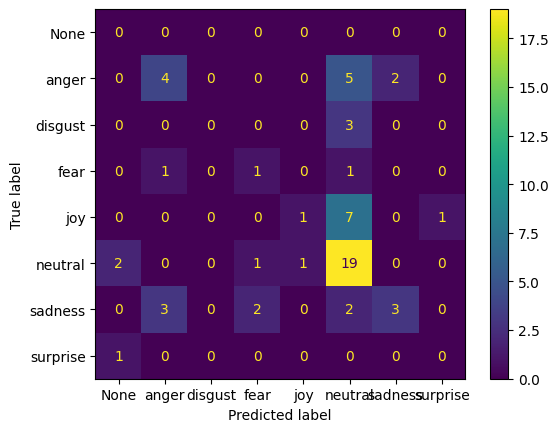

In [9]:
print('Confusion matrix SVM')
cf_matrix = confusion_matrix(test_labels,predictions)
print(cf_matrix)
display = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=label_set)
display.plot()

## End of notebook